In [2]:
import pandas as pd
import subprocess
from pathlib import Path
import json
from pprint import pprint
from tqdm import tqdm
import sys
from matplotlib import pyplot as plt
import copy

In [33]:
#  structure according to command prompt

BUILD_PATH = '../dis-viz-backend/build'

binary_files = [ # must be absolute path
    # '/home/insane/prapti/dis-viz/sample_inputs/bin/bubble-O3',
    # '/home/insane/prapti/dis-viz/sample_inputs/bin/multisource-O3',
    # '/home/insane/prapti/RAJAPerf/build/bin/raja-perf.exe',
    # '/home/prapti/RA_Kate/dis-viz/sample_inputs/bin/bubble-O3',
    '/home/prapti/RA_Kate/dis-viz/sample_inputs/bin/raja-perf-relwithdebuginfo-O2',
    '/home/prapti/RA_Kate/dis-viz/sample_inputs/bin/raja-perf-g-O3.exe'
    
]


args = [f"{BUILD_PATH}/DisViz", "-j", "--no-server"]
for bin in binary_files:
    args.append('-b')
    args.append(bin)

print(' '.join(args))
process = subprocess.Popen(args)
print("Returned: ", process.wait())

../dis-viz-backend/build/DisViz -j --no-server -b /home/prapti/RA_Kate/dis-viz/sample_inputs/bin/raja-perf-relwithdebuginfo-O2 -b /home/prapti/RA_Kate/dis-viz/sample_inputs/bin/raja-perf-g-O3.exe
Disassembling [██████████████████████████████████████████████████] :08s<00m:00s] 
Disassembling [██████████████████████████████████████████████████] :11s<00m:00s] 
Returned:  0


In [34]:
#JSON load

result = {}

for file in Path('json').glob('*.json'):
    with open(file, 'r') as f:
        result[file.stem] = json.load(f)

print([k for k in result.keys()])
sample = list(result.keys())[0]
print([k for k in result[sample].keys()])

['raja-perf-g-O3.exe', 'raja-perf-relwithdebug-openmp-mpi-O2', 'raja-perf-relwithdebuginfo-O2']
['functions', 'blocks_info']


In [5]:
# bin_result = result['raja-perf.exe']
bin_result = result['raja-perf-relwithdebug-openmp-mpi-O2']
blocks = bin_result['blocks_info']['memory_order_blocks']

In [6]:
# Check if there are inlines
for func in bin_result['functions']:
    if 'inlines' in func:
        print(func['name'])
        pprint(func['inlines'])
        break

main.cold
[{'callsite_file': '/usr/include/c++/13.2.1/type_traits',
  'callsite_line': 29,
  'name': 'std::ostream::operator<<(std::ostream& (*)(std::ostream&))',
  'ranges': [{'end': 88894, 'start': 88889}]},
 {'callsite_file': '/usr/include/c++/13.2.1/type_traits',
  'callsite_line': 51,
  'name': 'std::ostream::operator<<(std::ostream& (*)(std::ostream&))',
  'ranges': [{'end': 88978, 'start': 88973}]}]


In [19]:
#check if backedges >1
cnt = 0
for func in tqdm(bin_result['functions']):
    if 'loops' in func:
        for loop in func['loops']:
            if len(loop['backedges']) > 2:
                cnt = cnt + 1
print(cnt)


100%|██████████████████████████████████| 1861/1861 [00:00<00:00, 1573075.32it/s]

5


In [22]:
# get block with most instructions lines

def get_short_info(block):
    return {
        'name': block['name'],
        'start_adress': block['start_address'],
        'n_instructions': block['n_instructions'],
        'loops' : block['loops']
    }

sorted_blocks_by_instr = sorted(blocks, key=lambda b: b['n_instructions'], reverse=True) #[:60]
# pprint(list(map(get_short_info, sorted_blocks_by_instr))[:5])

In [17]:
# get block in loops with most instructions lines
def filter_by_loop(block):
    return len(block['loops']) > 0    

sorted_blocks_by_instr_in_loops = list(filter(filter_by_loop, sorted_blocks_by_instr))
# pprint(list(map(get_short_info, sorted_blocks_by_instr_in_loops))[:5])

In [32]:
# blocks with psedoloops 2761
cnt = 0
for block in blocks:
    if block['block_type'] == 'pseudoloop':
        print(block['start_address'])
        cnt += 1
print(cnt)

2761


In [10]:
# source-line correspondences of blocks with most instructions
counter = 0
for block in sorted_blocks_by_instr_in_loops:
    print(block['name'])
    for block_instr in block['instructions']:
        if 'correspondence' in block_instr:
            counter += 1
            print(block_instr['correspondence'])
            break
    print()
print(counter)

rajaperf::apps::EDGE3D::runSeqVariant(rajaperf::VariantID, unsigned long)::{lambda(long)#1}::operator(): B11855
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D.hpp': [271]}

rajaperf::apps::EDGE3D::runOpenMPVariant._omp_fn.0: B12016
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D.hpp': [271]}

rajaperf::apps::EDGE3D::runOpenMPVariant(rajaperf::VariantID, unsigned long)::{lambda(long)#1}::operator(): B12060
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D.hpp': [271]}

rajaperf::apps::EDGE3D::runOpenMPVariant(rajaperf::VariantID, unsigned long)::{lambda(long)#2}::operator(): B12114
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D.hpp': [271]}

rajaperf::apps::EDGE3D::runSeqVariant: B11915
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D.hpp': [271]}

rajaperf::apps::EDGE3D::runOpenMPVariant._omp_fn.0: B12006
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D-OMP.cpp': [47]}

rajaperf::apps::EDGE3D::runSeqVariant: B11897
{'/home/prapti/RA_Kate/RAJAPerf/src/apps/EDGE3D-Seq.cpp': [43]}

rajaperf

In [45]:
ins_to_find = ['vfmadd']

sorted_block_with_keywords = []

for block in tqdm(sorted_blocks_by_instr_in_loops):
	block_inserted = False
	for ins in block['instructions']:
		for keyword in ins_to_find:
			if keyword in ins['instruction'].lower():
				sorted_block_with_keywords.append(block)
				block_inserted = True
				break
		if block_inserted:
			break

[{ b['name'] + "  " + str(hex(b['start_address'])): [ins['instruction'] for ins in b['instructions']]} for b in sorted_block_with_keywords][0]


100%|███████████████████████████████████| 17606/17606 [00:00<00:00, 227739.98it/s]


IndexError: list index out of range

In [18]:
# give block name get address in hex

addr = next(filter(lambda b: b['name'] == 'rajaperf::algorithm::REDUCE_SUM::runOpenMPVariant: B40728', blocks))['start_address']
hex(addr)

'0xded80'

In [20]:
# Loops with high nesting

loops_len_sorted_blocks = sorted(blocks, key=lambda b: len(b['loops']), reverse=True)

list(map(lambda b: {'name': b['name'], 'address': hex(b['start_address']), 'instructions': b['instructions']}, loops_len_sorted_blocks[:1]))


[{'name': 'rajaperf::apps::MASS3DEA::runSeqVariant: B17305',
  'address': '0x66ae8',
  'instructions': [{'address': 420584,
    'correspondence': {'/home/prapti/RA_Kate/RAJAPerf/src/apps/MASS3DEA-Seq.cpp': [133]},
    'instruction': 'movsd (%r12),%xmm0'},
   {'instruction': 'mulsd %xmm2,%xmm0',
    'correspondence': {'/home/prapti/RA_Kate/RAJAPerf/src/apps/MASS3DEA-Seq.cpp': [133]},
    'address': 420590},
   {'address': 420594,
    'correspondence': {'/home/prapti/RA_Kate/RAJAPerf/src/apps/MASS3DEA-Seq.cpp': [133]},
    'instruction': 'mulsd 0x0(%r12,%rdi,8),%xmm0'},
   {'address': 420600,
    'correspondence': {'/home/prapti/RA_Kate/RAJAPerf/src/apps/MASS3DEA-Seq.cpp': [133]},
    'instruction': 'add $0x20,%r12'},
   {'instruction': 'mulsd 0x0(%r10,%rax,8),%xmm0',
    'correspondence': {'/home/prapti/RA_Kate/RAJAPerf/src/apps/MASS3DEA-Seq.cpp': [133]},
    'address': 420604},
   {'instruction': 'add $0x1,%rax',
    'correspondence': {'/home/prapti/RA_Kate/RAJAPerf/src/apps/MASS3DEA-S

Total number of blocks: 44541


(0.0, 30.0)

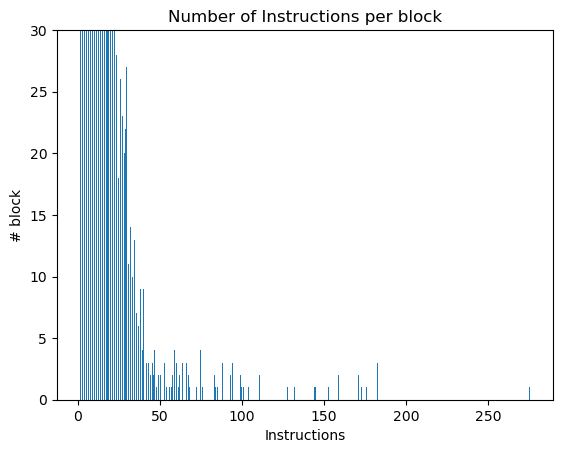

In [16]:
print(f"Total number of blocks: {len(blocks)}")
plt.hist(list(map(lambda block: block['n_instructions'], blocks)), bins=500)
plt.title("Number of Instructions per block")
plt.xlabel("Instructions")
plt.ylabel("# block")
plt.ylim(0, 30)

Total number of functions: 1599


Text(0, 0.5, 'Instructions')

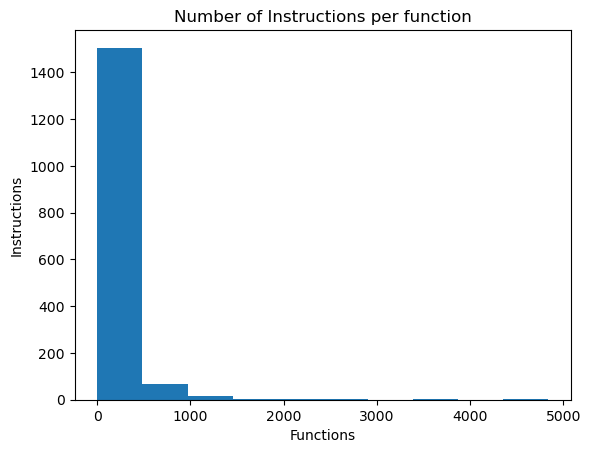

In [17]:
n_ins_per_function = {}

for block in blocks:
    if block['function_name'] not in n_ins_per_function:
        n_ins_per_function[block['function_name']] = 0
    n_ins_per_function[block['function_name']] += block['n_instructions']
    
print(f"Total number of functions: {len(n_ins_per_function)}")
plt.hist(n_ins_per_function.values())
plt.title("Number of Instructions per function")
plt.xlabel("Functions")
plt.ylabel("Instructions")

Total number of files: 360


Text(0, 0.5, 'Files')

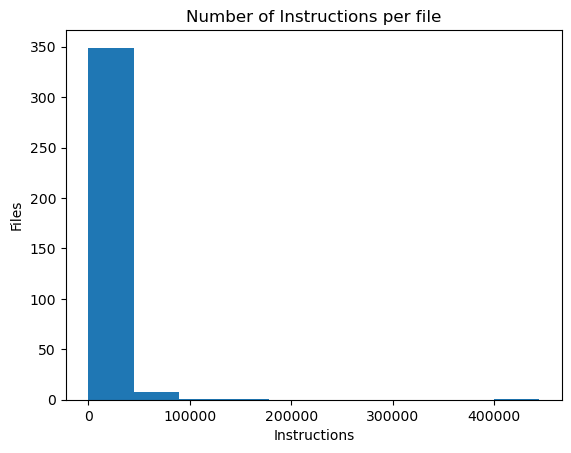

In [18]:
ins_count = {}
block_count = {}

for block in blocks:
    for instruction in block['instructions']:
        if 'correspondence' in instruction:
            for file_name in instruction['correspondence'].keys():
                if file_name not in ins_count:
                    ins_count[file_name] = 0
                    block_count[file_name] = 0
                ins_count[file_name] += block['n_instructions']
                block_count[file_name] += 1
        
        
print(f"Total number of files: {len(block_count)}")
plt.hist(ins_count.values())
plt.title("Number of Instructions per file")
plt.xlabel("Instructions")
plt.ylabel("Files")

# Loop lengths (Number of instructions per loop)

In [19]:
def flatten(xs):
    for x in xs:
        if isinstance(x, list) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [20]:
loops = list(flatten(filter(lambda loop: loop, map(lambda fn: copy.deepcopy(fn['loops']) if 'loops' in fn else [], bin_result['functions']))))

def flatten_inner_loops(loops):
    for loop in loops:
        if 'loops' in loop and loop['loops']:
            loops += flatten_inner_loops(loop['loops'])
    return loops
    
loops = flatten_inner_loops(loops)

print(f"Total inner+outer loops {len(loops)}")

loop_ids = list(range(len(loops)))

n_blocks = list(map(lambda loop: len(loop['blocks']), loops))

MAX_LOOPS = min(20000, len(loops))
n_instructions = []
for loop in tqdm(loops[:MAX_LOOPS]):
    cur_n_instructions = 0
    for block_number in loop['blocks']:
        cur_n_instructions += next(block for block in blocks if block['name'] == block_number)['n_instructions']
    n_instructions.append(cur_n_instructions)
    
df = pd.DataFrame(zip(n_blocks[:MAX_LOOPS], n_instructions), columns =["n_blocks", "n_instructions"], index=loop_ids[:MAX_LOOPS])
df

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_44412/3668465372.py", line 9, in <module>
    loops = flatten_inner_loops(loops)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_44412/3668465372.py", line 6, in flatten_inner_loops
    loops += flatten_inner_loops(loop['loops'])
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_44412/3668465372.py", line 6, in flatten_inner_loops
    loops += flatten_inner_loops(loop['loops'])
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_44412/3668465372.py", line 6, in flatten_inner_loops
    loops += flatten_inner_loops(loop['loops'])
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_44412/3668465372.py", line -1, in flatten_inner_loops
KeyboardInterrupt

During handling of the above exception, another exceptio

In [ ]:
loop_blocks = list(map(lambda loop: sorted(loop['blocks']), loops))

def loop_has_consecutive_blocks(loop, blocks):
    start_block = min(filter(lambda block: block['name'] in loop, blocks), key=lambda block: block['start_address'])
    sorted_blocks = sorted(blocks, key=lambda block: block['start_address'])
    start_block_idx = next(idx for idx, block in enumerate(sorted_blocks) if block['name'] == start_block['name'])
    
    for i in range(1, len(loop)):
        if sorted_blocks[start_block_idx + i]['name'] not in loop:
            return False
    return True

loops_without_consecutive_blocks_idx = [idx for idx, loop_block in tqdm(enumerate(loop_blocks)) if not loop_has_consecutive_blocks(loop_block, blocks)]
print(f"Total loops that contain non-consecutive blocks : {len(loops_without_consecutive_blocks_idx)}/{len(loop_blocks)}")

In [ ]:
#pprint([function for function in functions if function.name == 'rajaperf::KernelBase::hasVariantTuningDefined'][1].loops)

In [ ]:
non_consecutive_blocks_loop = []

consec_blocks_loop = []
nonconsec_blocks_loop = []

for i in loops_without_consecutive_blocks_idx:
    non_consecutive_blocks_loop.append(loop_blocks[i])

for non_cons_block_loop in tqdm(non_consecutive_blocks_loop):
    non_cons_blocks = []
    for block_name in non_cons_block_loop:
        for block in blocks:
            if block['name'] == block_name:
                non_cons_blocks.append(block)
                break
                
    nonconsec_blocks_loop.append(non_cons_blocks)
    non_cons_blocks.sort(key=lambda x: x['start_address'])
    
    first_block = non_cons_blocks[0]
    last_block = non_cons_blocks[-1]
    
    sorted_blocks = sorted(blocks, key=lambda block: block['start_address'])
    block_idx = next(idx for idx, block in enumerate(sorted_blocks) if block['name'] == first_block['name'])
    
    counter = 0
    current_consec_blocks = []
    for block in sorted_blocks[block_idx:]:
        counter += 1
        current_consec_blocks.append(block)
        if block['name'] == last_block['name']:
            break
    consec_blocks_loop.append(current_consec_blocks)

In [ ]:
for idx in loops_without_consecutive_blocks_idx[:2]:
    pprint(len(loop_blocks[idx]))

In [ ]:
non_consecutive_blocks_loop[:2]

In [ ]:
len_diff_loops = []
for cons_loop, noncons_loop in zip(consec_blocks_loop, nonconsec_blocks_loop):
    len_diff_loops.append(len(cons_loop) - len(noncons_loop))

df = pd.DataFrame(len_diff_loops, columns =["skipped_blocks"])
df_hist = df.skipped_blocks.value_counts().reset_index().rename(columns={'index': 'Skipped Blocks', 'skipped_blocks': 'Loop Counts'})
df_hist.sort_values(by=['Skipped Blocks'])

In [ ]:
# px.histogram(df, x='skipped_blocks', title="Skipped Blocks", labels={'x':'skipped_blocks'}, nbins=100)

plt.hist(df['skipped_blocks'])
plt.title("Skipped Blocks")
plt.xlabel("skipped_blocks")
plt.ylabel("")

In [ ]:
print("Some of the non-consecutive block loops are: ")
for idx in loops_without_consecutive_blocks_idx[:3]:
    pprint(loop_blocks[idx])